In [ ]:
!nvcc --version
!cat /proc/cpuinfo | grep name | cut -f2 -d: | uniq -c
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
      2  Intel(R) Xeon(R) CPU @ 2.00GHz
Thu Mar 31 07:21:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|    

In [ ]:
!pip install gdown --upgrade
!pip install exifread

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14774 sha256=01637c56d09001669b0896b22e8d2f06ea7e175bfedd4ff9be45c3a4d3028351
  Stored in directory: /root/.cache/pip/wheels/fb/c3/0e/c4d8ff8bfcb0461afff199471449f642179b74968c15b7a69c
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.2.2
    Uninstalling gdown-4.2.2:
      Successfully uninstalled gdown-4.2.2


In [ ]:
%cd /content
!rm -R /content/A-Siamese-Template-Matching-Method-for-SAR-and-Optical-Image
%cd /content
!git clone https://github.com/Fictionarry/A-Siamese-Template-Matching-Method-for-SAR-and-Optical-Image.git

/content
/content
Cloning into 'A-Siamese-Template-Matching-Method-for-SAR-and-Optical-Image'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 130 (delta 58), reused 95 (delta 32), pack-reused 0
Receiving objects: 100% (130/130), 14.95 MiB | 3.92 MiB/s, done.
Resolving deltas: 100% (58/58), done.


In [ ]:
%cd A-Siamese-Template-Matching-Method-for-SAR-and-Optical-Image/
!gdown --id 1OWnhz7KoODLz2NCmPlPHzIajTIlyFK6l
!unzip dataset_siamso.zip > /dev/null

/content/A-Siamese-Template-Matching-Method-for-SAR-and-Optical-Image
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1OWnhz7KoODLz2NCmPlPHzIajTIlyFK6l
To: /content/A-Siamese-Template-Matching-Method-for-SAR-and-Optical-Image/dataset_siamso.zip
100% 1.00G/1.00G [00:05<00:00, 170MB/s]


In [ ]:
%cd A-Siamese-Template-Matching-Method-for-SAR-and-Optical-Image/

import argparse
import logging
import sys
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

from utils.data import BasicDataset
from evaluate import evaluate, loss_fn
from model.siamso import SiamSO

dir_template = Path('./dataset/data/template/')
dir_search = Path('./dataset/data/search/')
dir_loc_csv = Path('./dataset/data_pair.csv')
dir_checkpoint = Path('./checkpoints/')






def train_net(net,
              device,
              epochs: int = 5,
              batch_size: int = 1,
              learning_rate: float = 1e-5,
              val_percent: float = 0.2,
              save_checkpoint: bool = True,
              img_scale: float = 0.5,
              amp: bool = False,
              pred_radius: int = 20):
    # 1. Create dataset
    dataset = BasicDataset(dir_template, dir_search, dir_loc_csv, img_scale)

    # 2. Split into train / validation partitions
    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

    # 3. Create data loaders
    loader_args = dict(batch_size=batch_size, num_workers=0, pin_memory=True)
    train_loader = DataLoader(train_set, shuffle=True, **loader_args)
    val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Checkpoints:     {save_checkpoint}
        Device:          {device.type}
        Images scaling:  {img_scale}
        Mixed Precision: {amp}
    ''')

    # 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    criterion = nn.CrossEntropyLoss()
    global_step = 0

    # 5. Begin training
    for epoch in range(epochs):
        net.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:
            for batch in train_loader:

                batch['template'] = batch['template'].to(device=device, dtype=torch.float32)
                batch['search'] = batch['search'].to(device=device, dtype=torch.float32)

                with torch.cuda.amp.autocast(enabled=amp):
                    pred = net(batch)
                    loss = loss_fn(batch, pred, pred_radius)

                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                grad_scaler.step(optimizer)
                grad_scaler.update()

                global_step += 1
                epoch_loss += loss.item()

                pbar.set_postfix(**{'loss (batch)': loss.item()})

                pbar.update(batch['template'].shape[0])

              # Evaluation round
            val_score = evaluate(net, val_loader, device, pred_radius)
            logging.info('loss: {}'.format(val_score))


        if save_checkpoint:
            Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
            torch.save(net.state_dict(), str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch + 1)))
            logging.info(f'Checkpoint {epoch + 1} saved!')


def get_args():
    parser = argparse.ArgumentParser(description='Train the UNet on images and target masks')
    parser.add_argument('--epochs', '-e', metavar='E', type=int, default=50, help='Number of epochs')
    parser.add_argument('--batch-size', '-b', dest='batch_size', metavar='B', type=int, default=2, help='Batch size')
    parser.add_argument('--learning-rate', '-l', metavar='LR', type=float, default=1e-4,
                        help='Learning rate', dest='lr')
    parser.add_argument('--load', '-f', type=str, default=False, help='Load model from a .pth file')
    parser.add_argument('--scale', '-s', type=float, default=1, help='Downscaling factor of the images')
    parser.add_argument('--validation', '-v', dest='val', type=float, default=15.0,
                        help='Percent of the data that is used as validation (0-100)')
    parser.add_argument('--amp', action='store_true', default=False, help='Use mixed precision')
    parser.add_argument('--bilinear', action='store_true', default=False, help='Use bilinear upsampling')
    parser.add_argument('--pred_radius', action='store_true', default=20)


    return parser.parse_args([])


if __name__ == '__main__':
    args = get_args()

    logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logging.info(f'Using device {device}')

    # Change here to adapt to your data
    # n_channels=3 for RGB images
    # n_classes is the number of probabilities you want to get per pixel
    net = SiamSO(n_channels=3, classes=1, bilinear=args.bilinear, device = device)

    logging.info(f'Network:\n'
                 f'\t{"Bilinear" if net.bilinear else "Transposed conv"} upscaling')

    if args.load:
        net.load_state_dict(torch.load(args.load, map_location=device))
        logging.info(f'Model loaded from {args.load}')

    net.to(device=device)
    try:
        train_net(net=net,
                  epochs=args.epochs,
                  batch_size=args.batch_size,
                  learning_rate=args.lr,
                  device=device,
                  img_scale=args.scale,
                  val_percent=args.val / 100,
                  amp=args.amp, 
                  pred_radius=args.pred_radius)
    except KeyboardInterrupt:
        torch.save(net.state_dict(), 'INTERRUPTED.pth')
        logging.info('Saved interrupt')
        sys.exit(0)


/content/A-Siamese-Template-Matching-Method-for-SAR-and-Optical-Image


INFO: Using device cuda
INFO: Network:
	Transposed conv upscaling
INFO: Creating dataset with 800 examples
INFO: Starting training:
        Epochs:          50
        Batch size:      2
        Learning rate:   0.0001
        Training size:   680
        Validation size: 120
        Checkpoints:     True
        Device:          cuda
        Images scaling:  1
        Mixed Precision: False
    
Validation round: 100%|██████████| 60/60 [00:50<00:00,  1.19batch/s]
                                                                    INFO: loss: -26.942312240600586
Epoch 1/50: 100%|██████████| 680/680 [18:43<00:00,  1.65s/img, loss (batch)=-205]
INFO: Checkpoint 1 saved!
Validation round: 100%|██████████| 60/60 [00:50<00:00,  1.20batch/s]
                                                                    INFO: loss: 44.409889221191406
Epoch 2/50: 100%|██████████| 680/680 [18:41<00:00,  1.65s/img, loss (batch)=0]
INFO: Checkpoint 2 saved!
Validation round: 100%|██████████| 60/60 [00:50<00

SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


INFO: Using device cuda


[Errno 2] No such file or directory: 'A-Siamese-Template-Matching-Method-for-SAR-and-Optical-Image/'
/content/A-Siamese-Template-Matching-Method-for-SAR-and-Optical-Image


INFO: Model loaded from checkpoints/checkpoint_epoch3.pth
INFO: Creating dataset with 800 examples
Epoch 1/1:   0%|          | 0/10 [00:00<?, ?img/s]

torch.Size([1, 299, 299])


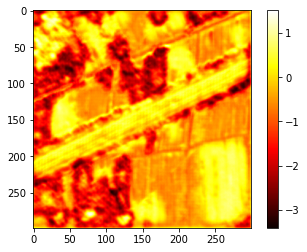

torch.Size([1, 999, 999])


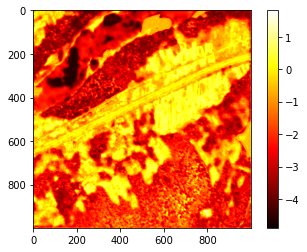

torch.Size([701, 701])


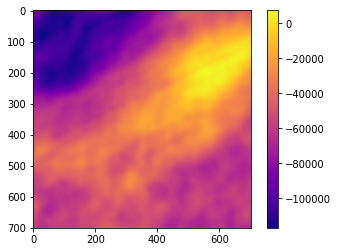

Epoch 1/1:  10%|█         | 1/10 [00:03<00:31,  3.54s/img]

tensor(44.0878, device='cuda:0')
torch.Size([1, 299, 299])


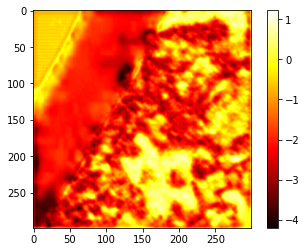

torch.Size([1, 999, 999])


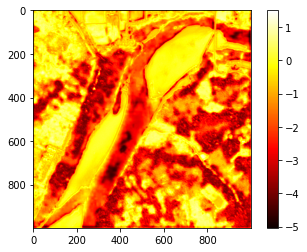

torch.Size([701, 701])


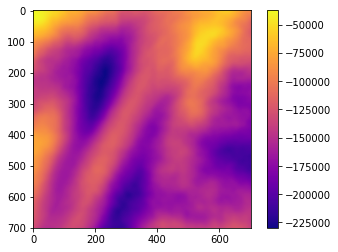

Epoch 1/1:  20%|██        | 2/10 [00:05<00:22,  2.85s/img]

tensor(0., device='cuda:0')
torch.Size([1, 299, 299])


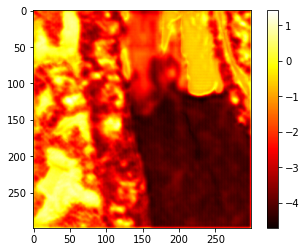

torch.Size([1, 999, 999])


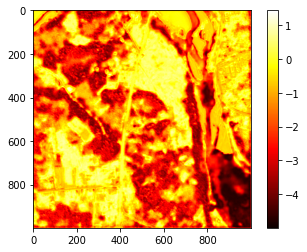

torch.Size([701, 701])


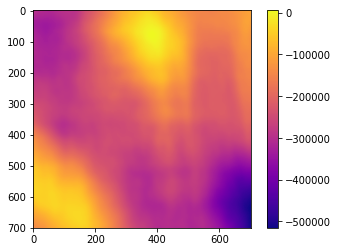

Epoch 1/1:  30%|███       | 3/10 [00:08<00:18,  2.64s/img]

tensor(3.6108, device='cuda:0')
torch.Size([1, 299, 299])


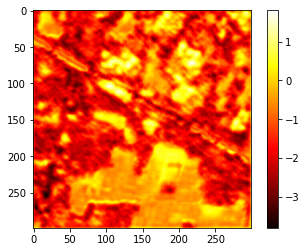

torch.Size([1, 999, 999])


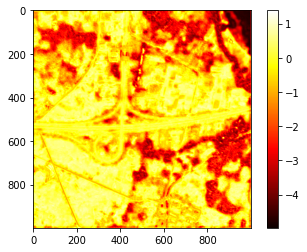

torch.Size([701, 701])


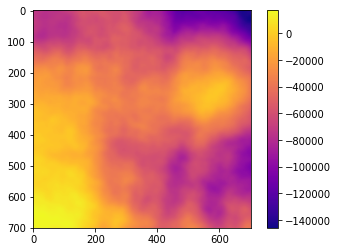

Epoch 1/1:  40%|████      | 4/10 [00:10<00:15,  2.53s/img]

tensor(121.3798, device='cuda:0')
torch.Size([1, 299, 299])


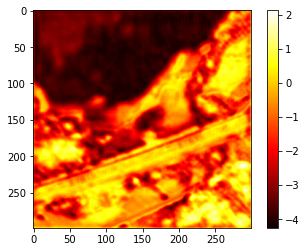

torch.Size([1, 999, 999])


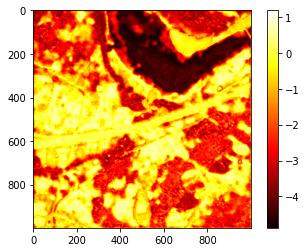

torch.Size([701, 701])


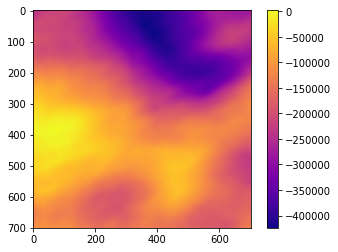

Epoch 1/1:  50%|█████     | 5/10 [00:13<00:12,  2.47s/img]

tensor(2.3646, device='cuda:0')
torch.Size([1, 299, 299])


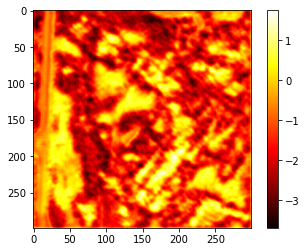

torch.Size([1, 999, 999])


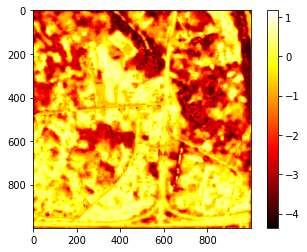

torch.Size([701, 701])


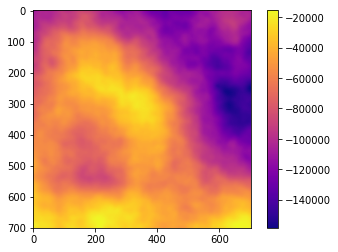

Epoch 1/1:  60%|██████    | 6/10 [00:15<00:09,  2.45s/img]

tensor(0., device='cuda:0')
torch.Size([1, 299, 299])


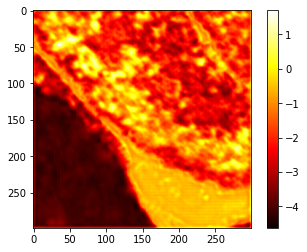

torch.Size([1, 999, 999])


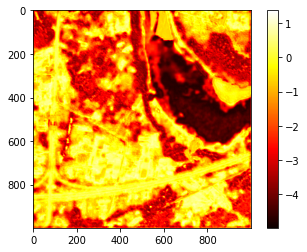

torch.Size([701, 701])


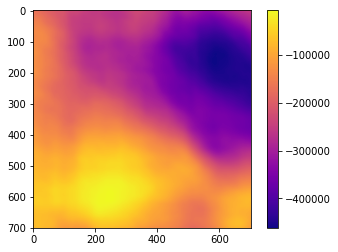

Epoch 1/1:  70%|███████   | 7/10 [00:17<00:07,  2.40s/img]

tensor(0., device='cuda:0')
torch.Size([1, 299, 299])


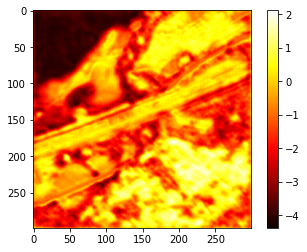

torch.Size([1, 999, 999])


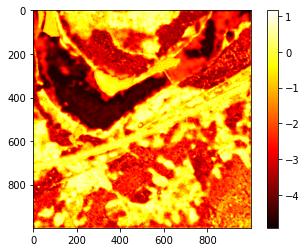

torch.Size([701, 701])


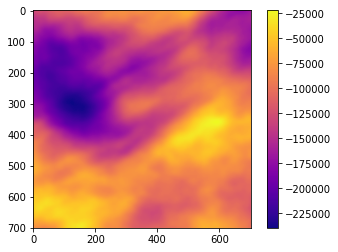

Epoch 1/1:  80%|████████  | 8/10 [00:20<00:04,  2.41s/img]

tensor(0., device='cuda:0')
torch.Size([1, 299, 299])


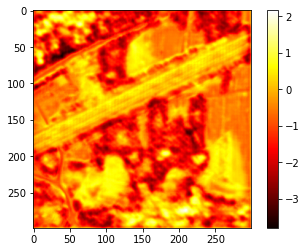

torch.Size([1, 999, 999])


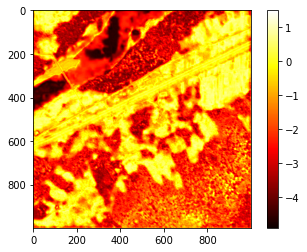

torch.Size([701, 701])


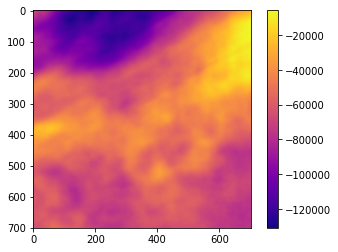

Epoch 1/1:  90%|█████████ | 9/10 [00:22<00:02,  2.40s/img]

tensor(0., device='cuda:0')
torch.Size([1, 299, 299])


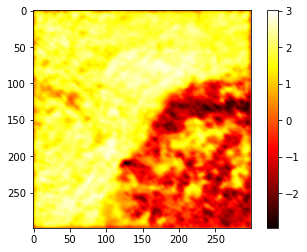

torch.Size([1, 999, 999])


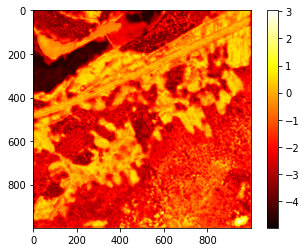

torch.Size([701, 701])


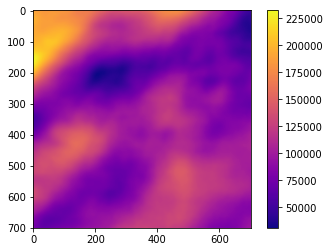

Epoch 1/1: 100%|██████████| 10/10 [00:25<00:00,  2.43s/img]

tensor(0., device='cuda:0')
torch.Size([1, 299, 299])


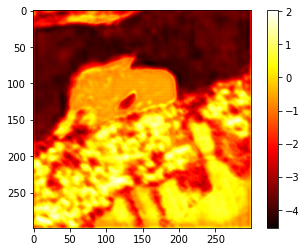

torch.Size([1, 999, 999])


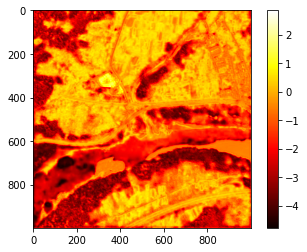

torch.Size([701, 701])


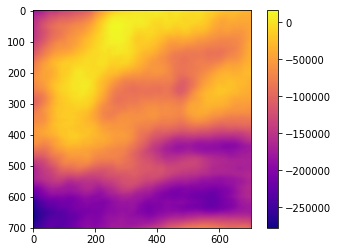

Epoch 1/1: 11img [00:27,  2.41s/img]                       

tensor(64.7856, device='cuda:0')
torch.Size([1, 299, 299])


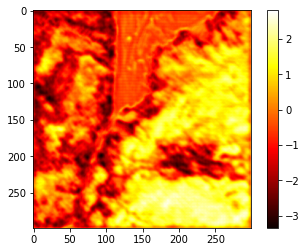

torch.Size([1, 999, 999])


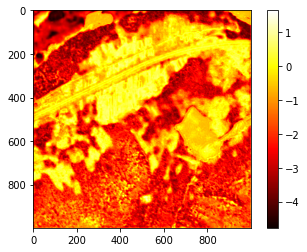

torch.Size([701, 701])


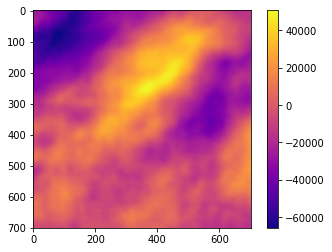

Epoch 1/1: 12img [00:29,  2.40s/img]

tensor(675.3898, device='cuda:0')
torch.Size([1, 299, 299])


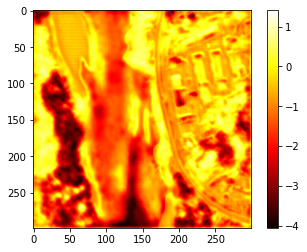

torch.Size([1, 999, 999])


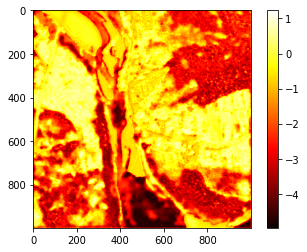

torch.Size([701, 701])


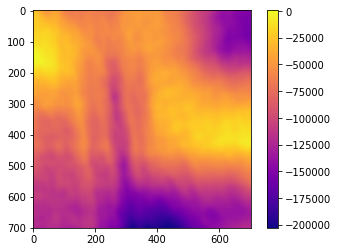

Epoch 1/1: 13img [00:32,  2.39s/img]

tensor(0.1205, device='cuda:0')
torch.Size([1, 299, 299])


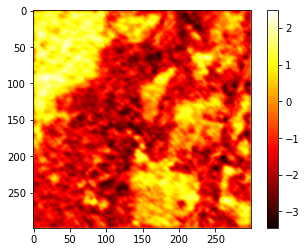

torch.Size([1, 999, 999])


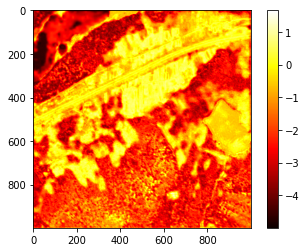

torch.Size([701, 701])


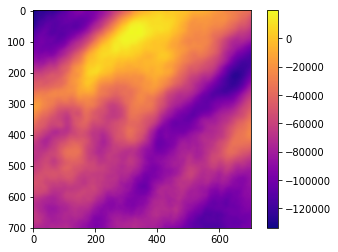

Epoch 1/1: 14img [00:34,  2.40s/img]

tensor(100.0583, device='cuda:0')
torch.Size([1, 299, 299])


Epoch 1/1: 14img [00:34,  2.49s/img]


KeyboardInterrupt: ignored

In [ ]:
%cd A-Siamese-Template-Matching-Method-for-SAR-and-Optical-Image/

import argparse
import logging
import sys
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

import matplotlib.pyplot as plt

from utils.data import BasicDataset
from evaluate import evaluate, loss_fn
from model.siamso import SiamSO

dir_template = Path('./dataset/data/template/')
dir_search = Path('./dataset/data/search/')
dir_loc_csv = Path('./dataset/data_pair.csv')
dir_checkpoint = Path('./checkpoints/')



def get_args():
    parser = argparse.ArgumentParser(description='Train the UNet on images and target masks')
    parser.add_argument('--load_model', '-lm', type=str, default='checkpoints/checkpoint_epoch3.pth', help='Load model from a .pth file')
    parser.add_argument('--amp', action='store_true', default=True, help='Use mixed precision')
    parser.add_argument('--bilinear', action='store_true', default=False, help='Use bilinear upsampling')

    return parser.parse_args([])


if __name__ == '__main__':
    args = get_args()

    logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logging.info(f'Using device {device}')

    # Change here to adapt to your data
    # n_channels=3 for RGB images
    # n_classes is the number of probabilities you want to get per pixel
    net = SiamSO(n_channels=3, classes=1, bilinear=args.bilinear, device=device)

    if args.load_model is not '':
        net.load_state_dict(torch.load(args.load_model, map_location=device))
        logging.info(f'Model loaded from {args.load_model}')

    net.to(device=device)
    net.eval()



    dataset = BasicDataset(dir_template, dir_search, dir_loc_csv, 1)
 
    loader_args = dict(batch_size=1, num_workers=0, pin_memory=True)
    loader = DataLoader(dataset, shuffle=False, **loader_args)

    global_step = 0

    # 5. Begin training
    for epoch in range(1):
        epoch_loss = 0
        with tqdm(total=10, desc=f'Epoch {epoch + 1}/{1}', unit='img') as pbar:
            for batch in loader:

                if global_step != -1:
                  batch['template'] = batch['template'].to(device=device, dtype=torch.float32)
                  batch['search'] = batch['search'].to(device=device, dtype=torch.float32)

                  with torch.no_grad():
                      template_feature = net.unet(batch['template']).squeeze(0)
                      print(template_feature.shape)
                      for i in range(template_feature.shape[0]):
                        plt.imshow(template_feature[i].cpu().numpy(), cmap='hot')
                        plt.colorbar()
                        plt.savefig('imgs/'+str(global_step)+'_'+str(i)+'.png')
                        plt.show()

                      search_feature = net.unet(batch['search']).squeeze(0)
                      print(search_feature.shape)
                      for i in range(search_feature.shape[0]):
                        plt.imshow(search_feature[i].cpu().numpy(), cmap='hot')
                        plt.colorbar()
                        plt.savefig('imgs/'+str(global_step)+'_2.png')
                        plt.show()


                      pred = net(batch)

                      loss = torch.tensor(0).to(device=pred.device, dtype=torch.float32)
                      # print(pred.shape)
                      for loc, response_map in zip(batch['loc'], pred[0]):

                          loc = loc.cpu().numpy()
                          sz = response_map.shape[0]
                          print(response_map.shape)
                          plt.imshow(response_map.cpu().numpy(), cmap='plasma')
                          plt.colorbar()
                          plt.savefig('imgs/'+str(global_step)+'_3.png')
                          plt.show()

                          response_map = torch.sigmoid(response_map)
                          pred_area = response_map[int(sz * loc[0]) : int(sz * loc[2]), int(sz * loc[1]) : int(sz * loc[3])]

                          alpha = (pred_area.shape[0] ** 2) / (sz ** 2)
                      loss = loss_fn(batch, pred, 20)
                      print(loss)


                global_step += 1

                pbar.update(batch['template'].shape[0])



# Demo

In [ ]:
%cd A-Siamese-Template-Matching-Method-for-SAR-and-Optical-Image/
!wget https://s3.amazonaws.com/DroneMapper_US/example/DroneMapper_Golf9_May2016.zip
!unzip DroneMapper_Golf9_May2016.zip > /dev/null
%cd DroneMapper_Golf9_May2016
!rm `ls | grep "a.JPG"`
%cd ..
!gdown --id '1rDJi3SQKharoDiv5jnKJsTsiSHgZRnAN'

[Errno 2] No such file or directory: 'A-Siamese-Template-Matching-Method-for-SAR-and-Optical-Image/'
/content/A-Siamese-Template-Matching-Method-for-SAR-and-Optical-Image
--2022-03-30 11:12:57--  https://s3.amazonaws.com/DroneMapper_US/example/DroneMapper_Golf9_May2016.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.171.48
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.171.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3557357967 (3.3G) [application/zip]
Saving to: ‘DroneMapper_Golf9_May2016.zip’

DroneMapper_Golf9_M 100%[===================>]   3.31G  61.8MB/s    in 54s     

2022-03-30 11:13:51 (62.5 MB/s) - ‘DroneMapper_Golf9_May2016.zip’ saved [3557357967/3557357967]

/content/A-Siamese-Template-Matching-Method-for-SAR-and-Optical-Image/DroneMapper_Golf9_May2016
/content/A-Siamese-Template-Matching-Method-for-SAR-and-Optical-Image
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated 

In [ ]:
template_dir = 'DroneMapper_Golf9_May2016'
# template_dir = '/content/QATM_pytorch/Attisholz'

# image_path = 'ortho.jpg'
image_path = '2016-6.jpg'

dataset = ImageDataset(Path(template_dir), image_path, rotation_csv="rotation_golf.csv", image_scale_factor=0.5, template_scale_factor = 0.12)

lu = [38.881581, -107.931278]
ru = [38.881581, -107.914214]
lb = [38.874358, -107.931278]
rb = [38.874358, -107.914214]

Attisholz

In [ ]:
%cd A-Siamese-Template-Matching-Method-for-SAR-and-Optical-Image/
!gdown --id '1pqijoPHw63IZQYu0JVq2I7lKTNKxya25'
!unzip Attisholz.zip > /dev/null
!gdown --id '1O0U_rgewcNiBi8Jc-cflfsec8r9hLg-s'

/content/A-Siamese-Template-Matching-Method-for-SAR-and-Optical-Image
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1pqijoPHw63IZQYu0JVq2I7lKTNKxya25
To: /content/A-Siamese-Template-Matching-Method-for-SAR-and-Optical-Image/Attisholz.zip
100% 78.1M/78.1M [00:00<00:00, 101MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1O0U_rgewcNiBi8Jc-cflfsec8r9hLg-s
To: /content/A-Siamese-Template-Matching-Method-for-SAR-and-Optical-Image/2020-03.jpg
100% 9.58M/9.58M [00:00<00:00, 91.7MB/s]


In [ ]:
template_dir = 'Attisholz'

# image_path = 'ortho.jpg'
image_path = '2020-03.jpg'
dataset = ImageDataset(Path(template_dir), image_path, rotation_csv="rotation_attisholz.csv", image_scale_factor=0.6, template_scale_factor = 0.3)

lu=[47.232058, 7.56053]
ru=[47.232058, 7.5998639]
lb=[47.212264, 7.56053]
rb=[47.212264, 7.5998639]

In [ ]:
%cd A-Siamese-Template-Matching-Method-for-SAR-and-Optical-Image/


import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from PIL import Image
from torchvision import models, transforms, utils
import copy


from utils.data import BasicDataset

from skimage import io,transform,data
import math

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, template_dir_path, image_name, rotation_csv=None, transform=None, image_scale_factor=0.3, template_scale_factor = 0.15):
        self.transform = transform
        if not self.transform:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
            ])
        template_path_all = [str(t_path) for t_path in list(template_dir_path.iterdir())]
        template_path_all.sort()
        # self.template_path = [template_path_all[i] for i in range(10)]
        self.template_path = template_path_all
        self.template_scale_factor = template_scale_factor

        self.image_scale_factor = image_scale_factor
        self.image_name = image_name
        
        self.image_raw = cv2.resize(cv2.cvtColor(cv2.imread(image_name), cv2.COLOR_BGR2RGB), (0, 0), fx=self.image_scale_factor, fy=self.image_scale_factor)
        
        self.rotation_df = None
        if rotation_csv:
            self.rotation_df = pd.read_csv(rotation_csv)
            
      
        self.image = torch.from_numpy(self.image_raw.copy()).permute(2,0,1).unsqueeze(0)
        
    def __len__(self):
        return len(self.template_names)
    
    def __getitem__(self, idx):
        template_path = self.template_path[idx]
        template = cv2.resize(cv2.cvtColor(cv2.imread(template_path), cv2.COLOR_BGR2RGB), (0, 0), fx=self.template_scale_factor, fy=self.template_scale_factor)
        rotation = 0
        if self.rotation_df is not None:
            rotation = -float(self.rotation_df.iloc[idx].rotation) / math.pi * 180
            # print(rotation)
        
        template = transform.rotate(template, rotation, resize=True)
        # print(template)
        template = torch.from_numpy(template).permute(2,0,1)

        
        return {'search': self.image, 
                    'image_raw': self.image_raw, 
                    'image_name': self.image_name,
                    'template': template.unsqueeze(0), 
                    'template_name': template_path, 
                    'template_h': template.size()[-2],
                   'template_w': template.size()[-1]}

[Errno 2] No such file or directory: 'A-Siamese-Template-Matching-Method-for-SAR-and-Optical-Image/'
/content/A-Siamese-Template-Matching-Method-for-SAR-and-Optical-Image


In [ ]:

import argparse
import logging
import sys
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

import matplotlib.pyplot as plt

from utils.data import BasicDataset
from evaluate import evaluate, loss_fn
from model.siamso import SiamSO

template_path = Path('./dataset/data/template/')
search_path = Path('./dataset/data/search/')
dir_loc_csv = Path('./dataset/data_pair.csv')
dir_checkpoint = Path('./checkpoints/')




def predict(net, batch):

    epoch_loss = 0

    batch['template'] = batch['template'].to(device=device, dtype=torch.float32)
    batch['search'] = batch['search'].to(device=device, dtype=torch.float32)

    with torch.no_grad():
        
        template_feature = net.unet(batch['template']).squeeze(0)
        print(template_feature.shape)
        for i in range(template_feature.shape[0]):
          plt.imshow(template_feature[i].cpu().numpy(), cmap='hot')
          plt.colorbar()
          plt.show()

        search_feature = net.unet(batch['search']).squeeze(0)
        print(search_feature.shape)
        for i in range(search_feature.shape[0]):
          plt.imshow(search_feature[i].cpu().numpy(), cmap='hot')
          plt.colorbar()
          plt.show()
        
        pred = net(batch)

        
        # print(pred.shape)
        for response_map in pred[0]:
            sz = response_map.shape[0]
            print(response_map.shape)
            plt.imshow(response_map.cpu().numpy(), cmap='plasma')
            plt.colorbar()
            plt.show()
        

    return pred.squeeze()




In [ ]:
import exifread

def pix2corr(x, y, w, h):
    lat = lu[0] - (lu[0] - lb[0]) * (y / h)
    lon = ((y / h) * lb[1] + (1 - y / h) * lu[1]) + (x / w) * ((y / h) * (rb[1] - lb[1]) + (1 - y / h) * (ru[1] - lu[1]))
    return [lat, lon]

def corr2pix(lat, lon, w, h):
    y = ((lu[0] - lat) / (lu[0] - lb[0])) * h
    x = (lon - ((y / h) * lb[1] + (1 - y / h) * lu[1])) / ((y / h) * (rb[1] - lb[1]) + (1 - y / h) * (ru[1] - lu[1])) * w
    return [x, y]


class PhotoExifInfo():
    def __init__(self,photo_path):
        self.photo_path = photo_path
        

    def get_tags(self):
        """获取照片信息"""
        image_content = open(self.photo_path, 'rb')
        tags = exifread.process_file(image_content)

        image_content.close()
        return tags

    def process_num(self, x):
        '''
        处理经纬度 将其转化为 xx.xxxxxx格式
        注意列表中的每一个元素 是 <class 'exifread.utils.Ratio'>
        由于最后一个是 10243/2000 这样的格式 需要手动将其处理 其余的使用 .num 方法就能获得到值
        :param x: 传入的经度和纬度
        :return: 处理好了经纬度
        '''
        # 处理列表中最后一个元素
        x_last = eval(str(x[-1]))
        #  转化
        new_x = x[0].num + x[1].num / 60 + x_last / 3600

        return new_x

    def get_lat_lon(self):
        """经纬度转换"""
        tags = self.get_tags()
        # 纬度
        LatRef = tags.get("GPS GPSLatitudeRef").values
        Lat = tags.get("GPS GPSLatitude").values
        Lat = self.process_num(Lat)
        if LatRef != "N":
            Lat = Lat * (-1)
        # 经度
        LonRef = tags.get("GPS GPSLongitudeRef").values
        Lon = tags.get("GPS GPSLongitude").values
        Lon = self.process_num(Lon)
        if LonRef != "E":
            Lon = Lon * (-1)
        return Lat,Lon


def plot_trace(image_raw, gt, pts, show=False, save_name=None, color=(255, 255, 255)):
    # plot result
    d_img = image_raw.copy()
    
    if show:
        plt.figure(figsize=(12,12), dpi=400)
        plt.axis('off')
        plt.imshow(d_img)

        plt.plot(gt[:,0], gt[:,1], 'o', markersize=2, color = 'lime', alpha = 0.6)
        plt.plot(gt[:,0], gt[:,1], linewidth=1, color='lime', alpha = 0.4)

        plt.plot(pts[:,0], pts[:,1], linewidth=1, color='lightsteelblue', alpha = 0.4)
        plt.plot(pts[:,0], pts[:,1], 'o', markersize=5, color = 'lightskyblue', alpha = 0.6)
    if save_name:
        cv2.imwrite(save_name, d_img[:,:,::-1])
    return d_img

In [ ]:
!gdown --id 1MK7NLQ59BSTt_V-_foCtXPAME7hQPxwV

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1MK7NLQ59BSTt_V-_foCtXPAME7hQPxwV
To: /content/A-Siamese-Template-Matching-Method-for-SAR-and-Optical-Image/checkpoint_epoch3.pth
100% 124M/124M [00:01<00:00, 96.7MB/s]


INFO: Using device cuda
INFO: Model loaded from checkpoint_epoch3.pth


torch.Size([1, 320, 280])


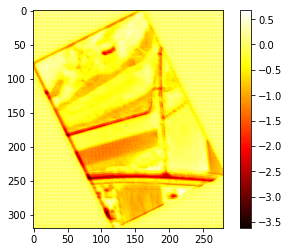

torch.Size([1, 2137, 2879])


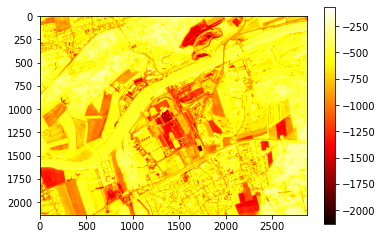

torch.Size([1818, 2600])


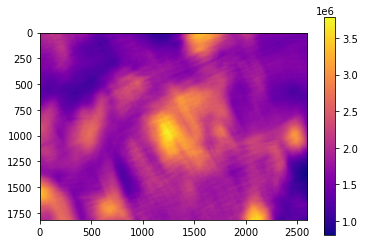

Attisholz/Attisholz_Flight_01_00002.jpg
torch.Size([1, 321, 281])


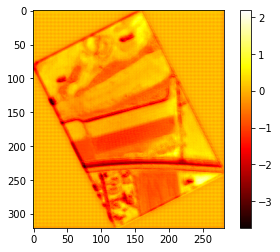

torch.Size([1, 2137, 2879])


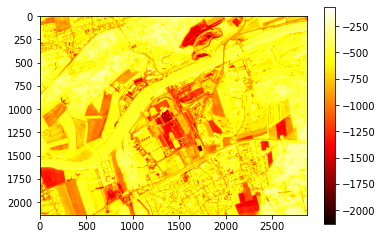

torch.Size([1817, 2599])


KeyboardInterrupt: ignored

In [ ]:


def get_args():
    parser = argparse.ArgumentParser(description='Train the UNet on images and target masks')
    parser.add_argument('--load_model', '-lm', type=str, default='checkpoint_epoch3.pth', help='Load model from a .pth file')
    parser.add_argument('--amp', action='store_true', default=True, help='Use mixed precision')
    parser.add_argument('--bilinear', action='store_true', default=False, help='Use bilinear upsampling')

    return parser.parse_args([])


if __name__ == '__main__':
    args = get_args()

    logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logging.info(f'Using device {device}')

    # Change here to adapt to your data
    # n_channels=3 for RGB images
    # n_classes is the number of probabilities you want to get per pixel
    net = SiamSO(n_channels=3, classes=1, bilinear=args.bilinear, device=device)

    if args.load_model is not '':
        net.load_state_dict(torch.load(args.load_model, map_location=device))
        logging.info(f'Model loaded from {args.load_model}')

    net.to(device=device)
    net.eval()

    pred_locs = []
    for data in dataset:
      # plt.imshow(data['template'].squeeze().permute(1,2,0).cpu().numpy())
      # plt.show()
      pred = predict(net, data)
      pred_loc = np.unravel_index(np.argmax(pred.cpu().numpy()), pred.shape)
      print(data['template_name'])
      # print(pred.shape)
      pred_loc_y = pred_loc[0] + data['template_h'] / 2
      pred_loc_x = pred_loc[1] + data['template_w'] / 2
      pred_loc = [pred_loc_x, pred_loc_y]
      pred_locs.append(pred_loc)

    print(pred_locs)
    geos = []
    gts = []
    errors = []
    h = 0
    w = 0


    for data in dataset:
      h, w = data['search'].shape[-2:]
      geos.append(list(PhotoExifInfo(data['template_name']).get_lat_lon()))
      c = corr2pix(float(geos[-1][0]), float(geos[-1][1]), w, h)
      gts.append(list(c))


    for pnt, gt in zip(pred_locs, geos):
      lat, lon = pix2corr(pnt[0], pnt[1], w, h)
      diff = [gt[0] - lat, gt[1] - lon]
      err = math.sqrt((diff[0] / 0.00000899)**2 + (diff[1] / 0.00001141)**2)
      errors.append(err)
      print(err)
    
    print(np.average(errors))
    # print(gts)

    gts = np.array(gts)
    pred_locs = np.array(pred_locs)
    # print(len(pts))
    # print(pts)
    d_img = plot_trace(dataset.image_raw, gts, pred_locs, show=True)



